In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ",device)

import argparse
import os
import numpy as np
def seed_everything(seed=1234):
    import random
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

device:  cuda


In [2]:
parser = argparse.ArgumentParser(description='Created by Yan Zhong ')
# dataset parameters
parser.add_argument('--lr', '--learning-rate', default=1e-2, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')


parser.add_argument('--seed', default=8, type=int, help='seed')
parser.add_argument('--sl', '--segment_length', default=147, type=int, help='the length of segmented data, '
                                                                           'the value should be n *21')
parser.add_argument('--nd', '--num_domains', default=2, type=int, help='split all data into num_domains domains')


parser.add_argument('--dt', '--data_transform', action="store_false", default=True,
                    help='apply augmentations on source data')
parser.add_argument('--db', action="store_false", default=True,
                    help='apply label balanced on source dataset')

parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('--lr-gamma', default=0.001, type=float, help='parameter for lr scheduler')
parser.add_argument('--lr-decay', default=0.75, type=float, help='parameter for lr scheduler')

parser.add_argument('--ne', '--num-epoch', type=int, default=30, help='all samples from source dataset '
                                                                      'should be used in a num_epoch')
parser.add_argument('--bs', '--batch_size', type=int, default= 32)
parser.add_argument('--nw', '--num_workers', type=int, default=0)



parser.add_argument('--optimizer', choices=['sgd', 'adam'], default='adam', help='Optimizer choice: SGD or Adam')

parser.add_argument('--weight_init', choices=['Gaussian', 'Xavier','Kaiming','No'], default='Xavier', help='weight init methods')



parser.add_argument('--ew',  type=float, default=0.2)
parser.add_argument('--gw', '--grl_weight', type=float, default=1.5,
                    help='it will be used as negative,so the input should > 0')


parser.add_argument('--eval_step', type=int, default=1)
flags = parser.parse_args(args=[])
args=flags

In [3]:
%cd /root/MSSDA_1212VER
!pwd


/root/MSSDA_1212VER
/root/MSSDA_1212VER


In [4]:
import argparse

from basedOnSplitDataset.utils import mmd,turn_to_dic,dic_div
from domainCluster.domain_seperaterANDcluster import *
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR
import torchvision.transforms as transforms
from myDataset.myDataLoader import ForeverDataIterator
from basedOnSplitDataset.SDmyDataset import *
from tensorboardX import SummaryWriter
import torch.optim as optim
from augmentation.augmentation import *
from basedOnSplitDataset.utils import *
from basedOnSplitDataset.SDmyDataset import DatasetFromSplitData,mySubset
from torch.utils.data import Subset, DataLoader
from tqdm import trange
from modules.domainSpecificLayer import domainSpecifictLayer
from modules.domainSpecificLayer import *
from basedOnSplitDataset.utils import *


2024-12-15 13:54:55.261144: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 13:54:55.321339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-15 13:54:56.204146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import torch.nn.init as init

from modules.new_discriminator import DomainDiscriminator,DomainAdversarialLoss
from modules.classifier import Classifier
from modules.oneDCNN import OneDCNNBackbone,domainSpecifictLayer
from basedOnSplitDataset.utils import Xavier_initialize_weights,kaiming_initialize_weights,Gaussian_weights_init
def myNet(device,pre_filename,totalDataset:DatasetFromSplitData,domain_num:int,centers, args: argparse.Namespace):
   
    tgt_accList=[]
    src_accList=[]
    true_labelList=[]
    # for split_index in trange(len(totalDataset.nameList)):
    for split_index in trange(1,2):
    #for lalal in trange(len(notoklist)):
        #split_index=notoklist[lalal]
        num_domain=args.nd
        print("=> runnnnnnning! =>")
        extractorList=[]
        classifierList=[]
        domain_discriList=[]
        domain_advList=[]
        optimizerList=[]
        lr_schedulerList=[]
        for i in range(domain_num):
            extractor = OneDCNNBackbone().to(device)
            classifier = domainSpecifictLayer(inplanes=256, planes=128, classifier_in=640).to(device)
            domain_discri = DomainDiscriminator(in_feature=640,hidden_size=320,batch_norm=False).to(device)
            domain_adv = DomainAdversarialLoss(domain_discri).to(device)
            
            if args.optimizer == 'sgd':
               
                optimizer = SGD(extractor.get_parameters(lr=args.lr)+classifier.get_parameters(lr=args.lr) + domain_discri.get_parameters(),
                             lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay, nesterov=True)
            elif args.optimizer == 'adam':
              
                optimizer = optim.Adam(extractor.get_parameters(lr=args.lr)+classifier.get_parameters(lr=args.lr) + domain_discri.get_parameters(lr=args.lr*0.1),
                            lr=args.lr, weight_decay=args.weight_decay)
            else:
                raise ValueError("Invalid optimizer choice. Please choose 'sgd' or 'adam'.")
            lr_scheduler = LambdaLR(optimizer, lambda x: args.lr * (1. + args.lr_gamma * float(x)) ** (-args.lr_decay))
            
            extractorList.append(extractor)
            classifierList.append(classifier)
            domain_discriList.append(domain_discri)
            domain_advList.append(domain_adv)
            optimizerList.append(optimizer)
            lr_schedulerList.append(lr_scheduler)
        
        extractorList=tuple(extractorList)
        classifierList=tuple(classifierList)
        domain_discriList=tuple(domain_discriList)
        domain_advList=tuple(domain_advList)
        optimizerList=tuple(optimizerList)
        lr_schedulerList=tuple(lr_schedulerList)


        
        tgt_acc,src_acc,true_label=train(device=device,k=domain_num,pre_filename=pre_filename,
                         totalDataset=totalDataset,extractorList=extractorList,classifierList= classifierList,centers=centers,
                         discriminatorList=domain_discriList,domain_advList=domain_advList,split_index=split_index,
                         optimizerList=optimizerList, lr_schedulerList=lr_schedulerList,args=args)
        
      
        print("##"*50)
        print(("i={}, tgt_acc={} ,src_acc={},true_label={}").format(split_index,tgt_acc[-1],src_acc,true_label))
        print("##"*50)
        tgt_accList.append(tgt_acc)
        src_accList.append(src_acc)
        true_labelList.append(true_label)
        

    return  tgt_accList,src_accList, true_labelList

[easydl] tensorflow not available!


In [6]:

import argparse

from torch import nn
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import os
import torch.nn.functional as F
from visualization.tSNE import *



def eval_model(device,k,pre_filename,args: argparse.Namespace,epoch,target_Loader:DataLoader,seed_used:int, 
               extractorList,classifierList,domain_advList,sortedTgtDomainTagList,filename:str):
    # k:num_domains
    criterion = nn.CrossEntropyLoss()

    
    predList=[]
    datanum=0
   
    
    countlist=[0 for _ in range(len(sortedTgtDomainTagList))]
    eval_data=target_Loader
    targetLoader_all_iter=ForeverDataIterator(target_Loader)
    inputs_t, labels_t, name_t, domains_t, distance_seq_t = next(targetLoader_all_iter)[:]
    from collections import Counter
    domains=np.array(domains_t).tolist()
   
    counter = Counter(domains)
    
    for i in range(len(sortedTgtDomainTagList)):
        domainTagtmp=sortedTgtDomainTagList[i]
        countlist[i]=counter[domainTagtmp]
    
    
    print("TTTTT" * 40)
    for domainTag in sortedTgtDomainTagList:
        running_loss = 0.0
        running_corrects = 0
        running_loss_domain=0.0
        # Iterate over data.
        
        
        
        extractor= extractorList[domainTag]
        classifier=classifierList[domainTag]
        domain_adv=domain_advList[domainTag]
        
        extractor.eval().to(device)
        classifier.eval().to(device)
        domain_adv.eval().to(device)
        
      
        rightList_domain_view=[]
        rightList_class_view=[]
    
        domian_count=[]
        class_count=[]
    
        label_1_feature=[]
        label_0_feature=[]
        
        for inputs_t, labels_t, name_t, domains_t, distance_seq_t in eval_data:
            with torch.no_grad():
                
    
                inputs_t = inputs_t.float().to(device)
                labels_t = labels_t.to(device)
                
                y_true=labels_t
                
               
                z_t = extractor(inputs_t)
    
                bs=inputs_t.shape[0]
                for i in range(bs):
                    if labels_t[i].item()==0:
                        label_0_feature.append(z_t[i].view(1,-1).cpu())
                    elif labels_t[i].item()==1:
                        label_1_feature.append(z_t[i].view(1,-1).cpu())
                
         
                _,y_t=classifier(z_t)
                predList.append(y_t)
                
                loss = criterion(y_t, labels_t)
               
                _, preds = torch.max(y_t, 1)
                
                # statistics
                running_loss += loss * inputs_t.size(0)
                running_corrects += torch.sum(preds == labels_t.data).item()
              
                for i in range(bs):
                    class_count.append(labels_t[i].item())
                    domian_count.append(domains_t[i].item())
                    if preds[i]==labels_t[i].data:
                        rightList_domain_view.append(domains_t[i].item())
                        rightList_class_view.append(labels_t[i].item())
                data_num = inputs_t.size(0)
        #print("label_0_feature[0].shape", label_0_feature[0].shape)
        #label_0_feature = torch.cat(label_0_feature, dim=0)
        #label_1_feature = torch.cat(label_1_feature, dim = 0)
        #print("label_0_feature.shape",label_0_feature.shape)
      
        #visualize_label(label_0_feature,label_1_feature,filename=pre_filename+'eval_'+str(epoch)+'_tsne.png')
    
        all_class_counts_dic = turn_to_dic(class_count)
        all_domain_counts_dic=turn_to_dic(domian_count)
        right_class_counts_domain_view_dic=turn_to_dic(rightList_domain_view)
        right_class_counts_class_view_dic = turn_to_dic(rightList_class_view)
        
      
    
        epoch_loss = running_loss / data_num
        epoch_acc = running_corrects / data_num
        epoch_loss_domain = running_loss_domain 
        
        log = 'Eval: Epoch: {},domainTag={}, Loss: {:.4f}, i_tgt_Acc: {:.4f} '.format(epoch,domainTag, epoch_loss, epoch_acc)
        print(log)
        
    # print("--target" * 10)
        

    
    # fenmu=sum(countlist)
    # summed=predList[0]*countlist[0]/fenmu
    # if len(sortedTgtDomainTagList)>1:
    #     for i in range(1,len(sortedTgtDomainTagList)):
    #         summed+=predList[i]*countlist[i]/fenmu
    # summed_list =torch.divide(summed,len(sortedTgtDomainTagList))
    
    fenmu=len(sortedTgtDomainTagList)
    summed=predList[0]/fenmu
    if len(sortedTgtDomainTagList)>1:
        for i in range(1,len(sortedTgtDomainTagList)):
            summed+=predList[i]/fenmu
    summed_list=summed
    
     

    
 
    _, sum_preds = torch.max(summed_list, 1)
    after_sum_running_corrects = torch.sum(sum_preds == y_true).item()
    after_sum_tgt_acc=after_sum_running_corrects/ data_num
    print("-----" * 40)
    print("Eval: Epoch: {}, after summing the logistic values from the domain {}，TGT_Acc: {:.4f}".format(epoch, sortedTgtDomainTagList, after_sum_tgt_acc))
    print("TTTTT" * 40)
    return after_sum_tgt_acc

In [7]:
from basedOnSplitDataset.utils import seed_everything,HLoss,euclidean_distance,turn_to_dic,dic_div
from torchvision.transforms.transforms import *
from PIL import Image


def train(device,pre_filename,k:int,totalDataset:DatasetFromSplitData,domain_advList,
          extractorList,classifierList,discriminatorList,centers,
          optimizerList,lr_schedulerList,split_index,
          args: argparse.Namespace):

    seed_used=args.seed
    path = './'+pre_filename+'/result/'
    
    num_epoch = args.ne
    batch_size = args.bs
    num_workers = args.nw

    

    nameList = totalDataset.nameList.tolist()
    target_indices = [nameList[split_index]]
    # print("target_indices",target_indices)
    nameList.pop(split_index)
    source_indices = nameList

    
    source = mySubset(totalDataset, source_indices, transform_part1=None, transform_part2 = None, balanced=0)
    target = mySubset(totalDataset, target_indices, transform_part1=None, transform_part2 = None, balanced=0)
    
   
    domain_tag_list=[i for i in range(k)]


    
    sourceLoader = DataLoader(dataset=source, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                              drop_last=True)
    targetLoader = DataLoader(dataset=target, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                              drop_last=True)
    
    targetLoader_all= DataLoader(dataset=target, batch_size=len(target), shuffle=True, num_workers=num_workers,
                              drop_last=False)
    
    source_iter=ForeverDataIterator(sourceLoader)
    target_iter=ForeverDataIterator(targetLoader)

    targetLoader_all_iter=ForeverDataIterator(targetLoader_all)
    inputs_t, labels_t, name_t, domains_t, distance_seq_t = next(targetLoader_all_iter)[:]
    from collections import Counter
    domains=np.array(domains_t).tolist()

    counter = Counter(domains)
    
    
    
    
    
    distances_to_centers = calculate_distances_to_centers(targetLoader_all, model=clusterEncoder, device=device, centers=centers,pca_dim=2, L2norm=False, )
    
    #c= np.sum(distances_to_centers, axis=0)
    #here
    c=np.amax(distances_to_centers, axis=0)
    sorted_indices = np.argsort(c, axis=None)
    
    #here
    sortedTgtDomainTagList=[]
    sortedTgtDomainTagList.append(sorted_indices[0])
    sortedTgtDomainTagList.append(sorted_indices[1])


    sortedTgtDomainTagList = sorted(sortedTgtDomainTagList)
    
    
    print("train_start")
    writerPath=path+'runs/domain_num_' + str(k) + '_seed_'+str(seed_used)
    writer=SummaryWriter(writerPath)
    
    
    entropy_criterion = HLoss()

    source_iter_byDomain_list=[]
    for i in range(k):
        domain_tag=domain_tag_list[i]
        i_source_dataset_byDomain = mySubset_bydomain(dataset=totalDataset, name_indices=source_indices,domain_tag=domain_tag, transform_part1=None, transform_part2=None,balanced=1)
        i_sourceLoader = DataLoader(dataset=i_source_dataset_byDomain, batch_size=batch_size, shuffle=True, num_workers=num_workers,drop_last=True)
        i_source_iter = ForeverDataIterator(i_sourceLoader)
        source_iter_byDomain_list.append(i_source_iter)
  


    eval_acc_list = []
    
    true_label=-1
    src_acc=-100
    
    
    
    for epoch in trange(num_epoch):
        print("SSSSS" * 40)
        for domainTag in sortedTgtDomainTagList:
            running_loss_class = 0.
            running_correct_class = 0.
            running_loss_domain = 0.
            running_correct_domain = 0.
            running_loss_entropy = 0.
            running_loss_taxonomy = 0.
    
    
            rightList_domain_view = []
            rightList_class_view = []
    
            domian_count = []
            class_count = []
    
            s_feature = []
            t_feature = []
            s_domain = []
            t_domain = []
            s_label = []
            t_label = []
            
            extractor=extractorList[domainTag]
            classifier=classifierList[domainTag]
            domain_adv=domain_advList[domainTag]
            discriminator=discriminatorList[domainTag]
            optimizer=optimizerList[domainTag]
            lr_scheduler=lr_schedulerList[domainTag]
        
            extractor.train()
            classifier.train()
            domain_adv.train()
            discriminator.train()
            
            iter_per_epopch=len(source_iter_byDomain_list[domainTag])
            # print("iter_per_epopch",iter_per_epopch)
                                
            for i in range(iter_per_epopch):
             
                
                optimizer.zero_grad()
                    
                inputs_s, labels_s, name_s, domains_s, distance_seq_s = next(source_iter_byDomain_list[domainTag])[:]
                inputs_t, labels_t, name_t, domains_t, distance_seq_t = next(target_iter)[:]
                
                true_label=labels_t[0]
                #print("domains_s.shape",domains_s.shape)
                
                inputs_s = inputs_s.float().to(device)
                inputs_t = inputs_t.float().to(device)
    
                labels_s = labels_s.to(device)
    
                z_s = extractor(inputs_s)
                z_t = extractor(inputs_t)
                

                mid_s,y_s = classifier(z_s)
                mid_t,y_t = classifier(z_t)
                
                loss_class = nn.CrossEntropyLoss(reduction='none')(y_s, labels_s).float()
                loss_class = torch.mean(loss_class, dim=0, keepdim=True)
    
                loss_entropy = entropy_criterion(y_s).float()
                
                loss_domain=domain_adv(mid_s, mid_t)
                domain_acc = domain_adv.domain_discriminator_accuracy
                
                gw=args.gw
                total_loss = loss_class +  gw* loss_domain+args.ew*loss_entropy
                
                total_loss.backward()
                optimizer.step()
                lr_scheduler.step()
                
                _, pred_class = torch.max(y_s, 1)
    
                
                running_loss_class += loss_class.item() * inputs_s.size(0)
                running_correct_class += torch.sum(pred_class == labels_s.data)
                running_loss_entropy += loss_entropy.item() * inputs_s.size(0)
                running_loss_domain += loss_domain.item() * inputs_s.size(0)  
                running_correct_domain += domain_acc* inputs_s.size(0)
        
                bs = inputs_s.shape[0]
               
                for i in range(bs):
                    class_count.append(labels_s[i].item())
                    domian_count.append(domains_s[i].item())
    
                    if pred_class[i] == labels_s[i].data:
                        rightList_domain_view.append(domains_s[i].item())
                        rightList_class_view.append(labels_s[i].item())
            
              
        
            all_class_counts_dic = turn_to_dic(class_count)
            all_domain_counts_dic = turn_to_dic(domian_count)
            right_class_counts_domain_view_dic = turn_to_dic(rightList_domain_view)
            right_class_counts_class_view_dic =  turn_to_dic(rightList_class_view)
            

            tmp=iter_per_epopch*args.bs
           
            epoch_loss_class = running_loss_class/ tmp
            epoch_acc_class = running_correct_class / tmp
            epoch_loss_domain = running_loss_domain /tmp
            epoch_acc_domain = running_correct_domain /tmp
            epoch_loss_entropy = running_loss_entropy /tmp
            
    
            
            if  epoch==num_epoch-1:
                src_acc=epoch_acc_class
    
            print("domain number: {}, loss class: {}, acc class: {}, loss domain: {}, ".format(domainTag,epoch_loss_class,epoch_acc_class,epoch_loss_domain))
        
        
        
        if epoch % args.eval_step == 0:
            print("SSSSS" * 40)
            acc = eval_model(device=device,k=k,args=args,seed_used=seed_used,target_Loader=targetLoader_all,
                             extractorList=extractorList,classifierList=classifierList,
                             epoch=epoch,domain_advList=domain_advList,sortedTgtDomainTagList=sortedTgtDomainTagList,
                             pre_filename=path,filename=(path + 'domain_num_' + str(k) + '_seed_'+str(seed_used)  + 'eval.txt'))
            #nni.report_intermediate_result(acc)
            eval_acc_list.append(acc)
     
        
        

    return  eval_acc_list,src_acc,true_label

In [8]:

%matplotlib inline

In [9]:
k=args.nd
bs=batch_size=args.bs
seed_used=args.seed

 start Getting data
all data segmented
get pseudo domain tages
now domain_split
before preprocess_features (6983, 20)
self.pca_dim 2
after preprocess_features (6983, 2)


100%|██████████| 23/23 [00:03<00:00,  5.78it/s]


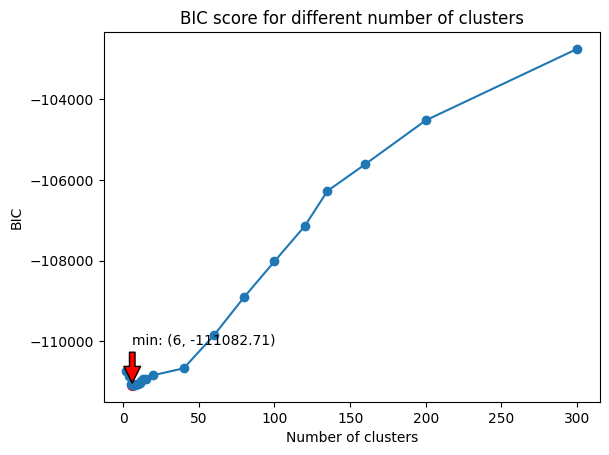

In [10]:

file_path = ".txt"
from datetime import datetime

current_datetime = datetime.now()

formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H%M%S")

from basedOnSplitDataset.loadAndCluster import giveDomainTag



from basedOnSplitDataset.SDmyDataset import DatasetFromSplitData 
from preTrain.comet import COMET
from preTrain.comet import COMET
from datetime import datetime
import os
import numpy as np
from torch.utils.tensorboard import SummaryWriter

working_directory='./preTrain/model_weight/' 
if not os.path.exists(working_directory):
    os.makedirs(working_directory)
start_time = datetime.now()
seed_everything(1234)
pretrain_model = COMET(
    input_dims=16,
    device=device,
    lr=1e-4,
    depth=10,
    batch_size=64,
    output_dims=512,
    flag_use_multi_gpu=False,
    after_epoch_callback=None,
)

pretrain_model.load(f"{working_directory}pretrain_model20240709_147c16_ver9.pt")

path='./clusterResult'
writerPath=path+'runs/domain_num_' + str(k) + '_seed_'+str(seed_used)
writer=SummaryWriter(writerPath)

clusterEncoder=pretrain_model._net

from torchvision.transforms.transforms import *
from PIL import Image
import torchvision.transforms as transforms
import argparse
from basedOnSplitDataset.SDmyDataset import DatasetFromSplitData,mySubset
from torch import nn
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import os
import torch.nn.functional as F
from visualization.tSNE import *


from domainCluster.domain_seperaterANDcluster_BIC_getClusterCentroid import domain_split
from domainCluster.domain_seperaterANDcluster_BIC_getClusterCentroid import fit_gmm_with_dataloader
from domainCluster.domain_seperaterANDcluster_BIC_getClusterCentroid import calculate_distances_to_centers
from getTotoalDataset import totalDataset

total_Loader = DataLoader(dataset=totalDataset, batch_size=batch_size, shuffle=False, num_workers=0,drop_last=False)

print("get pseudo domain tages")

clusters_0 = np.ones([len(totalDataset), ])
domain_tag,centers = domain_split(total_dataloader=total_Loader,model=clusterEncoder,
                            device=device,cluster_before=clusters_0,filename=path + '/nmi.txt',
                            epoch=-1, batchsize=batch_size,nmb_cluster=k, method='Kmeans',
                            pca_dim=2, whitening=False, L2norm=False,writer=writer)






before=totalDataset.name_segmented
totalDataset.set_cluster_segmented(np.array(domain_tag))

# totalDataset.set_distance_segmented(distances_between_centers)
after=totalDataset.name_segmented





totaldataset=totalDataset

In [11]:
k=args.nd
seed=args.seed
seed_everything(seed=seed)
file_path_new = (formatted_datetime + str('domain_num_') + str(k) + str('_') + str("output_seed_") + str(seed) + file_path)


folder_path = './LeaveOneTest/DANN_baseline' + formatted_datetime
os.makedirs(folder_path, exist_ok=True)
parser_filename = folder_path + '/parser_info.txt'
with open(parser_filename, 'a+') as f:
    f.write(str(args))

domains_tags=totaldataset.pseudo_domain_segmented
from collections import Counter
element_count = Counter(domains_tags)
len(element_count) 


6

In [12]:
len(totalDataset.nameList)

135

In [13]:
# target info:
# patient 127, lable 0, man , age 32, duration 0.1

In [14]:
tgt_acclist,src_accList,true_labelList=myNet(device=device,totalDataset=totaldataset,args=args,domain_num=len(element_count.items()),pre_filename=folder_path,centers=centers )  

  0%|          | 0/1 [00:00<?, ?it/s]

=> runnnnnnning! =>
train_start



  0%|          | 0/30 [00:00<?, ?it/s]

SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
domain number: 0, loss class: 0.6653256047339666, acc class: 0.7083333730697632, loss domain: 0.6929744056292942, 



  3%|▎         | 1/30 [00:00<00:28,  1.01it/s]

domain number: 5, loss class: 0.6598414239429292, acc class: 0.6889880895614624, loss domain: 0.6943021927561078, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 0,domainTag=0, Loss: 0.6871, i_tgt_Acc: 0.5128 
Eval: Epoch: 0,domainTag=5, Loss: 0.6929, i_tgt_Acc: 0.5128 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 0, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5128
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


  7%|▋         | 2/30 [00:01<00:25,  1.09it/s]

domain number: 5, loss class: 0.5293336297784533, acc class: 0.78125, loss domain: 0.6933290986787706, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 1,domainTag=0, Loss: 0.7281, i_tgt_Acc: 0.3846 
Eval: Epoch: 1,domainTag=5, Loss: 0.7946, i_tgt_Acc: 0.3077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 1, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 10%|█         | 3/30 [00:02<00:24,  1.11it/s]

domain number: 5, loss class: 0.34865710068316685, acc class: 0.8467261791229248, loss domain: 0.6920030599548703, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 2,domainTag=0, Loss: 0.4568, i_tgt_Acc: 0.7692 
Eval: Epoch: 2,domainTag=5, Loss: 0.7058, i_tgt_Acc: 0.5897 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 2, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.7949
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 13%|█▎        | 4/30 [00:03<00:22,  1.14it/s]

domain number: 5, loss class: 0.22463577914805638, acc class: 0.8898809552192688, loss domain: 0.69046570005871, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 3,domainTag=0, Loss: 1.1530, i_tgt_Acc: 0.3333 
Eval: Epoch: 3,domainTag=5, Loss: 1.0060, i_tgt_Acc: 0.3590 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 3, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2821
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 17%|█▋        | 5/30 [00:04<00:21,  1.19it/s]

domain number: 5, loss class: 0.11866321184095882, acc class: 0.9598214626312256, loss domain: 0.6887087538128808, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 4,domainTag=0, Loss: 1.2311, i_tgt_Acc: 0.4359 
Eval: Epoch: 4,domainTag=5, Loss: 1.1154, i_tgt_Acc: 0.4103 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 4, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 20%|██        | 6/30 [00:05<00:19,  1.22it/s]

domain number: 5, loss class: 0.04693130527933439, acc class: 0.9895833730697632, loss domain: 0.6875096814973014, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 5,domainTag=0, Loss: 2.5320, i_tgt_Acc: 0.1795 
Eval: Epoch: 5,domainTag=5, Loss: 2.0423, i_tgt_Acc: 0.1026 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 5, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0513
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 23%|██▎       | 7/30 [00:05<00:18,  1.24it/s]

domain number: 5, loss class: 0.02260008549672507, acc class: 0.9970238208770752, loss domain: 0.6855226783525377, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 6,domainTag=0, Loss: 2.8384, i_tgt_Acc: 0.2308 
Eval: Epoch: 6,domainTag=5, Loss: 1.7778, i_tgt_Acc: 0.2821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 6, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0513
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 27%|██▋       | 8/30 [00:06<00:17,  1.25it/s]

domain number: 5, loss class: 0.008477087310027508, acc class: 1.0, loss domain: 0.6829761862754822, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 7,domainTag=0, Loss: 2.4905, i_tgt_Acc: 0.2821 
Eval: Epoch: 7,domainTag=5, Loss: 1.8934, i_tgt_Acc: 0.2821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 7, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1795
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 30%|███       | 9/30 [00:07<00:16,  1.27it/s]

domain number: 5, loss class: 0.0034101242116386338, acc class: 1.0, loss domain: 0.6815778414408366, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 8,domainTag=0, Loss: 2.8977, i_tgt_Acc: 0.2821 
Eval: Epoch: 8,domainTag=5, Loss: 3.1619, i_tgt_Acc: 0.1282 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 8, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 33%|███▎      | 10/30 [00:08<00:15,  1.28it/s]

domain number: 5, loss class: 0.001976992412459194, acc class: 1.0, loss domain: 0.6798752915291559, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 9,domainTag=0, Loss: 3.5117, i_tgt_Acc: 0.2564 
Eval: Epoch: 9,domainTag=5, Loss: 2.5473, i_tgt_Acc: 0.2051 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 9, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.0769
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 37%|███▋      | 11/30 [00:09<00:14,  1.28it/s]

domain number: 5, loss class: 0.0011100786352818389, acc class: 1.0, loss domain: 0.6789615296182179, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 10,domainTag=0, Loss: 3.3041, i_tgt_Acc: 0.2821 
Eval: Epoch: 10,domainTag=5, Loss: 3.1285, i_tgt_Acc: 0.1282 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 10, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 40%|████      | 12/30 [00:09<00:13,  1.30it/s]

domain number: 5, loss class: 0.0010899056602890294, acc class: 1.0, loss domain: 0.6761679450670878, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 11,domainTag=0, Loss: 3.5043, i_tgt_Acc: 0.2821 
Eval: Epoch: 11,domainTag=5, Loss: 2.7377, i_tgt_Acc: 0.2051 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 11, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1026
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 43%|████▎     | 13/30 [00:10<00:12,  1.31it/s]

domain number: 5, loss class: 0.0008693446559066485, acc class: 1.0, loss domain: 0.6764533519744873, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 12,domainTag=0, Loss: 3.2318, i_tgt_Acc: 0.3077 
Eval: Epoch: 12,domainTag=5, Loss: 3.1810, i_tgt_Acc: 0.1538 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 12, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 47%|████▋     | 14/30 [00:11<00:12,  1.32it/s]

domain number: 5, loss class: 0.0005800925587425896, acc class: 1.0, loss domain: 0.6749975794837588, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 13,domainTag=0, Loss: 3.6902, i_tgt_Acc: 0.2821 
Eval: Epoch: 13,domainTag=5, Loss: 2.6915, i_tgt_Acc: 0.2308 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 13, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1795
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 50%|█████     | 15/30 [00:12<00:11,  1.32it/s]

domain number: 5, loss class: 0.0005925295187071676, acc class: 1.0, loss domain: 0.6748615247862679, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 14,domainTag=0, Loss: 4.0148, i_tgt_Acc: 0.2564 
Eval: Epoch: 14,domainTag=5, Loss: 3.0456, i_tgt_Acc: 0.2051 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 14, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 53%|█████▎    | 16/30 [00:12<00:10,  1.32it/s]

domain number: 5, loss class: 0.0004179042734904215, acc class: 1.0, loss domain: 0.6746498459861392, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 15,domainTag=0, Loss: 4.2959, i_tgt_Acc: 0.2564 
Eval: Epoch: 15,domainTag=5, Loss: 2.8311, i_tgt_Acc: 0.2051 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 15, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 57%|█████▋    | 17/30 [00:13<00:09,  1.33it/s]

domain number: 5, loss class: 0.00032451543943136043, acc class: 1.0, loss domain: 0.6762309670448303, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 16,domainTag=0, Loss: 4.2890, i_tgt_Acc: 0.2821 
Eval: Epoch: 16,domainTag=5, Loss: 2.7094, i_tgt_Acc: 0.2051 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 16, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 60%|██████    | 18/30 [00:14<00:09,  1.33it/s]

domain number: 5, loss class: 0.00023316903527648676, acc class: 1.0, loss domain: 0.6758155397006443, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 17,domainTag=0, Loss: 4.3761, i_tgt_Acc: 0.2821 
Eval: Epoch: 17,domainTag=5, Loss: 2.6664, i_tgt_Acc: 0.2051 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 17, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.1282
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 63%|██████▎   | 19/30 [00:15<00:08,  1.33it/s]

domain number: 5, loss class: 0.00029222523638357717, acc class: 1.0, loss domain: 0.6767384324754987, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 18,domainTag=0, Loss: 4.3374, i_tgt_Acc: 0.2821 
Eval: Epoch: 18,domainTag=5, Loss: 2.3779, i_tgt_Acc: 0.3077 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 18, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2051
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 67%|██████▋   | 20/30 [00:15<00:07,  1.31it/s]

domain number: 5, loss class: 0.0002495060921535783, acc class: 1.0, loss domain: 0.6784386521294004, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 19,domainTag=0, Loss: 4.3727, i_tgt_Acc: 0.2821 
Eval: Epoch: 19,domainTag=5, Loss: 2.4254, i_tgt_Acc: 0.2821 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 19, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2308
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 70%|███████   | 21/30 [00:16<00:06,  1.32it/s]

domain number: 5, loss class: 0.00022340291720216295, acc class: 1.0, loss domain: 0.6789111495018005, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 20,domainTag=0, Loss: 4.2952, i_tgt_Acc: 0.2821 
Eval: Epoch: 20,domainTag=5, Loss: 2.0955, i_tgt_Acc: 0.3590 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 20, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2564
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 73%|███████▎  | 22/30 [00:17<00:06,  1.32it/s]

domain number: 5, loss class: 0.0003075661987254751, acc class: 1.0, loss domain: 0.6812676446778434, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 21,domainTag=0, Loss: 4.6310, i_tgt_Acc: 0.3077 
Eval: Epoch: 21,domainTag=5, Loss: 2.0300, i_tgt_Acc: 0.3846 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 21, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.2564
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 77%|███████▋  | 23/30 [00:18<00:05,  1.32it/s]

domain number: 5, loss class: 0.0002719087750024517, acc class: 1.0, loss domain: 0.6834586433001927, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 22,domainTag=0, Loss: 4.0811, i_tgt_Acc: 0.3077 
Eval: Epoch: 22,domainTag=5, Loss: 1.5885, i_tgt_Acc: 0.4872 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 22, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4103
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 80%|████████  | 24/30 [00:18<00:04,  1.32it/s]

domain number: 5, loss class: 0.0003519561266460057, acc class: 1.0, loss domain: 0.6871723561059861, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 23,domainTag=0, Loss: 4.3172, i_tgt_Acc: 0.3590 
Eval: Epoch: 23,domainTag=5, Loss: 1.5881, i_tgt_Acc: 0.4872 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 23, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4872
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 83%|████████▎ | 25/30 [00:19<00:03,  1.32it/s]

domain number: 5, loss class: 0.00028094427328878303, acc class: 1.0, loss domain: 0.688280619326092, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 24,domainTag=0, Loss: 5.6461, i_tgt_Acc: 0.3077 
Eval: Epoch: 24,domainTag=5, Loss: 1.4263, i_tgt_Acc: 0.5385 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 24, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.3846
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 87%|████████▋ | 26/30 [00:20<00:03,  1.33it/s]

domain number: 5, loss class: 0.0002561668616614216, acc class: 1.0, loss domain: 0.6930056299482074, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 25,domainTag=0, Loss: 5.0062, i_tgt_Acc: 0.3590 
Eval: Epoch: 25,domainTag=5, Loss: 1.3923, i_tgt_Acc: 0.5641 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 25, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4872
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 90%|█████████ | 27/30 [00:21<00:02,  1.34it/s]

domain number: 5, loss class: 0.00031578191694626144, acc class: 1.0, loss domain: 0.6948509216308594, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 26,domainTag=0, Loss: 5.4218, i_tgt_Acc: 0.3846 
Eval: Epoch: 26,domainTag=5, Loss: 1.3192, i_tgt_Acc: 0.6667 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 26, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.4103
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 93%|█████████▎| 28/30 [00:21<00:01,  1.35it/s]

domain number: 5, loss class: 0.0003027744740912957, acc class: 1.0, loss domain: 0.6967885891596476, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 27,domainTag=0, Loss: 5.7335, i_tgt_Acc: 0.4359 
Eval: Epoch: 27,domainTag=5, Loss: 1.2673, i_tgt_Acc: 0.6923 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 27, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5641
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


 97%|█████████▋| 29/30 [00:22<00:00,  1.36it/s]

domain number: 5, loss class: 0.0003717281282920989, acc class: 1.0, loss domain: 0.7009770018713815, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 28,domainTag=0, Loss: 6.4199, i_tgt_Acc: 0.4872 
Eval: Epoch: 28,domainTag=5, Loss: 1.1743, i_tgt_Acc: 0.7179 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 28, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5641
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


100%|██████████| 1/1 [00:23<00:00, 23.55s/it]

domain number: 5, loss class: 0.0003270499326477182, acc class: 1.0, loss domain: 0.7019833014124915, 
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
Eval: Epoch: 29,domainTag=0, Loss: 6.9464, i_tgt_Acc: 0.5641 
Eval: Epoch: 29,domainTag=5, Loss: 1.1813, i_tgt_Acc: 0.7436 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Eval: Epoch: 29, after summing the logistic values from the domain [0, 5]，TGT_Acc: 0.5385
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT